In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None

from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed,Bidirectional
from collections import Counter
from datetime import datetime
from sklearn.ensemble import IsolationForest
%matplotlib inline


rcParams['figure.figsize'] = 12, 6
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
def data(accion):
  df_aut = pd.read_csv("/content/drive/MyDrive/Dataset/df_aut.csvs")
  variables=["SIZEStockSize","Nr_Trades","WA_StockPrc","SYMBOL","manip","Ri","S1_MA30","T1_MA30","O3_SD30","fecha"]
  dfv=df_aut.loc[:,variables]
  acc=dfv[dfv["SYMBOL"]==accion]
  df1=acc.copy()
  df=df1.loc[:,["SIZEStockSize","Nr_Trades","WA_StockPrc","Ri","S1_MA30","T1_MA30","O3_SD30"]].dropna()
  acc1=acc.dropna()
  scaler = MinMaxScaler(feature_range=(0, 1))
  data_s_train = scaler.fit_transform(df)
  train = data_s_train.copy()
  train= train.reshape(train.shape[0],1,train.shape[1])
  return train,acc, acc1

In [ ]:
def autoencoder(X):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(64, input_shape= (train.shape[1], train.shape[2]), return_sequences=True))
  model.add(tf.keras.layers.ReLU()) 
  model.add(tf.keras.layers.LSTM(32, recurrent_dropout=0.2,return_sequences=True))
  model.add(tf.keras.layers.ReLU()) 
  model.add(tf.keras.layers.Dropout(0.15)) 
  model.add(tf.keras.layers.LSTM(16, recurrent_dropout=0.2,return_sequences=True))
  model.add(tf.keras.layers.ReLU()) 
  model.add(tf.keras.layers.Dropout(0.15))
  model.add(tf.keras.layers.LSTM(8, recurrent_dropout=0.2,return_sequences=False))
  model.add(tf.keras.layers.ReLU()) 
  model.add(tf.keras.layers.Dropout(0.15))
  model.add(tf.keras.layers.RepeatVector(train.shape[1]))
  model.add(tf.keras.layers.LSTM(8, recurrent_dropout=0.2,return_sequences=True))
  model.add(tf.keras.layers.ReLU()) 
  model.add(tf.keras.layers.Dropout(0.15))
  model.add(tf.keras.layers.LSTM(16, recurrent_dropout=0.2,return_sequences=True))
  model.add(tf.keras.layers.ReLU()) 
  model.add(tf.keras.layers.Dropout(0.15))
  model.add(tf.keras.layers.LSTM(32, recurrent_dropout=0.2,return_sequences=True))
  model.add(tf.keras.layers.ReLU()) 
  model.add(tf.keras.layers.Dropout(0.15))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.ReLU()) 
  model.add(TimeDistributed(Dense(train.shape[2])))
  return model

In [ ]:
train, acc, acc1= data("BIF")

In [ ]:
model= autoencoder(train)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),loss=tf.losses.MeanSquaredError())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             18432     
                                                                 
 re_lu (ReLU)                (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 32)             12416     
                                                                 
 re_lu_1 (ReLU)              (None, 1, 32)             0         
                                                                 
 dropout (Dropout)           (None, 1, 32)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 16)             3136      
                                                                 
 re_lu_2 (ReLU)              (None, 1, 16)             0

In [ ]:
def error(x):
  error=[]
  x_pred = model.predict(x)
  error=train-x_pred
  error=error.reshape(error.shape[0],error.shape[2])
  error=pd.DataFrame(error,columns = ["Vol","Trades","Price","Ri","S1_MA30","T1_MA30","O3_SD30"])
  error_2=pd.DataFrame(error.pow(2,axis=1))
  return error, error_2



In [ ]:
#pd.options.display.float_format = '{:.7f}'.format

In [ ]:
Var_ajust=["Vol_aj","Trades_aj","Price_aj","Ri_aj","S1_MA30_aj","T1_MA30_aj","O3_SD30_aj"]
error_col=["Vol","Trades","Price","Ri","S1_MA30","T1_MA30","O3_SD30"]

def error_ajust():
  error_ajust=[]
  error_2_ajust=[]
  for a in range(7):
    error[Var_ajust[a]] = [1 if x > error[error_col[a]].mean()+3*error[error_col[a]].std() else 0 for x in error[error_col[a]]]
    error_2[Var_ajust[a]] = [1 if x > error_2[error_col[a]].mean()+3*error_2[error_col[a]].std() else 0 for x in error_2[error_col[a]]] 
  error_ajust, error_2_ajust = error.loc[:,Var_ajust], error_2.loc[:,Var_ajust]
  #error_2_ajust= error_2.loc[:,Var_ajust]
  return error_ajust, error_2_ajust

In [ ]:
tf.random.set_seed(123)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True
)


In [ ]:
n_epochs=500
batch_size=80
history=model.fit(train,train,epochs=n_epochs,validation_split=0.2, shuffle=False,batch_size=batch_size,callbacks=[early_stopping],).history

In [ ]:
error, error_2 = error(train)

43/43 [==============================] - 2s 4ms/step


In [ ]:
error_ajust, error_2_ajust= error_ajust()


In [ ]:
error_2_ajust

,Vol_aj,Trades_aj,Price_aj,Ri_aj,S1_MA30_aj,T1_MA30_aj,O3_SD30_aj
0,0,1,0,0,1,1,0
1,0,0,0,0,1,1,0
2,0,0,0,0,1,1,0
3,0,0,0,0,1,1,0
4,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...
1343,0,0,1,0,0,0,0
1344,0,0,1,0,0,0,0
1345,0,0,1,0,0,0,0
1346,0,0,1,0,0,0,0


In [ ]:
var_test=(["Vol_aj","Trades_aj","Price_aj"],["Ri_aj","S1_MA30_aj","T1_MA30_aj","O3_SD30_aj"],
         ["Vol_aj","Trades_aj","Price_aj","Ri_aj","S1_MA30_aj","T1_MA30_aj","O3_SD30_aj"])
#var_test=(["Vol","Trades","Price"],["Ri","S1_MA30","T1_MA30","O3_SD30"],
 #        ["Vol","Trades","Price","Ri","S1_MA30","T1_MA30","O3_SD30"])
indices=("test1","test2","test3")
score=("score1","score2","score3")

In [ ]:
for i in range(3):
    df2=error_2_ajust.loc[:,var_test[i]]
    #df2=error_2.loc[:,var_test[i]]
    X = df2
    iforest = IsolationForest(n_estimators=2000, max_samples='auto', 
                          contamination=0.01, max_features=len(var_test[i]), 
                          bootstrap=True, n_jobs=-1, random_state=1)
    pred= iforest.fit_predict(X)
    error[score[i]] = [-1*s - iforest.offset_ for s in iforest.decision_function(X)]
    error[indices[i]] = [1 if (-1*s - iforest.offset_) >0.5  else 0  for s in iforest.decision_function(X)] 
    

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
error["cai"]=error["test1"]+error["test2"]+error["test3"]
error["score_ave"]=(error["score1"]+error["score2"]+error["score3"])/3

In [ ]:
score_ave=error[error["cai"]>0]

In [ ]:
Counter(score_ave.cai)

Counter({3: 5, 2: 110})

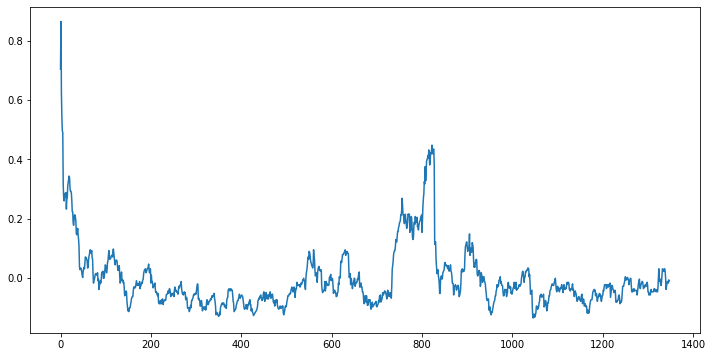

In [ ]:
plt.plot(error.T1_MA30)
plt.show()

In [ ]:
manip= acc["manip"][:len(train)].values

In [ ]:
error["manip"]=manip

In [ ]:
error[error["cai"]>2][error["manip"]==1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Vol,Trades,Price,Ri,S1_MA30,T1_MA30,O3_SD30,Vol_aj,Trades_aj,Price_aj,...,O3_SD30_aj,score1,test1,score2,test2,score3,test3,cai,score_ave,manip
644,0.387331,-0.090850,0.155873,0.374519,-0.043693,-0.009731,-0.078655,1,0,0,...,0,0.770256,1,0.710876,1,0.763446,1,3,0.748192,1
1004,0.433101,-0.090855,0.225746,0.250846,-0.010703,-0.015087,0.020527,1,0,0,...,0,0.770256,1,0.710876,1,0.763446,1,3,0.748192,1
1347,0.942470,0.020235,0.691620,0.708882,-0.077232,-0.009779,-0.134226,1,0,1,...,0,0.826442,1,0.710876,1,0.799991,1,3,0.779103,1


In [ ]:
error[error["manip"]==1]

,Vol,Trades,Price,Ri,S1_MA30,T1_MA30,O3_SD30,Vol_aj,Trades_aj,Price_aj,...,O3_SD30_aj,score1,test1,score2,test2,score3,test3,cai,score_ave,manip
327,-0.031666,-0.053795,-0.188866,-0.010290,0.020636,-0.089912,0.007980,0,0,0,...,0,0.418977,0,0.399533,0,0.333480,0,0,0.383997,1
644,0.387331,-0.090850,0.155873,0.374519,-0.043693,-0.009731,-0.078655,1,0,0,...,0,0.770256,1,0.710876,1,0.763446,1,3,0.748192,1
645,-0.035205,-0.090851,0.109271,-0.014501,0.027385,-0.023101,0.230226,0,0,0,...,0,0.418977,0,0.399533,0,0.333480,0,0,0.383997,1
1004,0.433101,-0.090855,0.225746,0.250846,-0.010703,-0.015087,0.020527,1,0,0,...,0,0.770256,1,0.710876,1,0.763446,1,3,0.748192,1
1005,-0.044595,-0.016778,0.183046,-0.013127,0.007446,-0.025777,0.068951,0,0,0,...,0,0.418977,0,0.399533,0,0.333480,0,0,0.383997,1
1347,0.942470,0.020235,0.691620,0.708882,-0.077232,-0.009779,-0.134226,1,0,1,...,0,0.826442,1,0.710876,1,0.799991,1,3,0.779103,1


In [ ]:
error[error["cai"]>2]

,Vol,Trades,Price,Ri,S1_MA30,T1_MA30,O3_SD30,Vol_aj,Trades_aj,Price_aj,...,O3_SD30_aj,score1,test1,score2,test2,score3,test3,cai,score_ave,manip
0,0.197185,0.427663,-0.158684,0.077139,0.870763,0.704163,-0.330472,0,1,0,...,0,0.765423,1,0.824411,1,0.800825,1,3,0.796887,0
644,0.387331,-0.090850,0.155873,0.374519,-0.043693,-0.009731,-0.078655,1,0,0,...,0,0.770256,1,0.710876,1,0.763446,1,3,0.748192,1
809,0.084500,0.427654,0.181548,-0.059507,0.096748,0.353879,-0.096372,0,1,0,...,0,0.765423,1,0.748503,1,0.749403,1,3,0.754443,0
1004,0.433101,-0.090855,0.225746,0.250846,-0.010703,-0.015087,0.020527,1,0,0,...,0,0.770256,1,0.710876,1,0.763446,1,3,0.748192,1
1347,0.942470,0.020235,0.691620,0.708882,-0.077232,-0.009779,-0.134226,1,0,1,...,0,0.826442,1,0.710876,1,0.799991,1,3,0.779103,1


In [ ]:
acc1["fecha"]=pd.to_datetime(acc1["fecha"], format="%Y/%m/%d %H:%M:%S")

In [ ]:
acc1["cai"]=error["cai"].values

In [ ]:
acc1["manip"]=error["manip"].values

In [ ]:
sosp=acc1[acc1["cai"]>2]

In [ ]:
manip=acc1[acc1["manip"]==1]

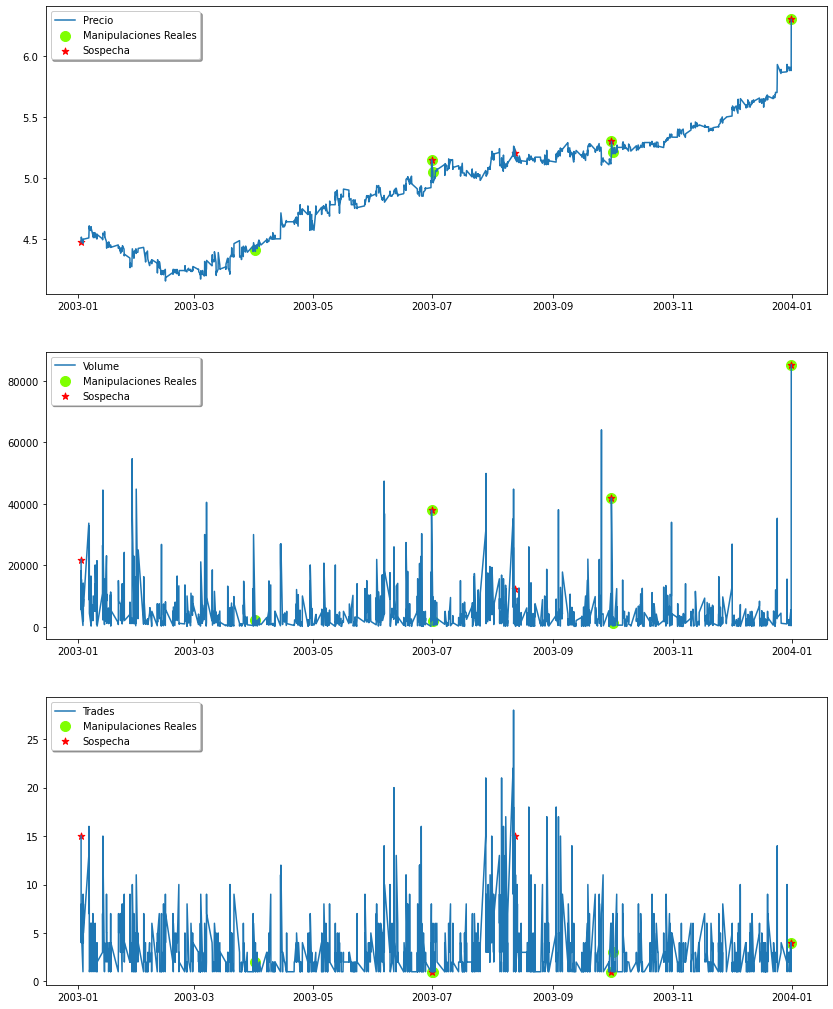

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(14, 18))

ax1.plot(acc1.fecha,acc1.WA_StockPrc,label="Precio")
ax1.scatter(manip.fecha,manip.WA_StockPrc, label="Manipulaciones Reales",color='#7FFF00', marker='o',s=100)
ax1.scatter(sosp.fecha, sosp.WA_StockPrc, label="Sospecha",color='r', marker='*',s=50)
ax1.legend(shadow=True, loc='upper left')
#ax1.set_title("ZAP")


ax2.plot(acc1.fecha,acc1.SIZEStockSize,label="Volume")
ax2.scatter(manip.fecha,manip.SIZEStockSize, label="Manipulaciones Reales",color='#7FFF00', marker='o',s=100)
ax2.scatter(sosp.fecha, sosp.SIZEStockSize, label="Sospecha",color='r', marker='*',s=50)
ax2.legend(shadow=True, loc='upper left')

ax3.plot(acc1.fecha,acc1.Nr_Trades,label="Trades")
ax3.scatter(manip.fecha,manip.Nr_Trades, label="Manipulaciones Reales",color='#7FFF00', marker='o',s=100)
ax3.scatter(sosp.fecha, sosp.Nr_Trades, label="Sospecha",color='r', marker='*',s=50)
ax3.legend(shadow=True, loc='upper left')


#plt.savefig("/content/drive/MyDrive/Colab Notebooks/Doctorado/P2/Fig/BIF_RESULT.pdf")
plt.show()